# Dropsonde Based Surface Evaporation per flight

This routine calculates the surface evaporation from the dropsondes over sea surface. The formula relies on Howland et al. (1983,https://doi.org/10.1175/1520-0493(1983)111<2255:TMBOTN>2.0.CO;2 )

E=C_d*rho_a*(q_s-q_a)*v --> (actually this formula comes from Rao et al. (1981))

C_d   : drag coefficient( 1.4e-3 for v< 13 m/s, 1.6e-3 for v>13m/s)
rho_a : air density at sea level
q_s   : saturation specific humidity
q_a   : actual specific humidity

## Configuration

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
from simplified_flight_leg_handling import simplified_run_grid_main
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
import Performance
performance=Performance.performance()

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Predefinitions

In [2]:
campaign="HALO_AC3"
ar_of_day="AR_entire_2"
calibrated_hamp=True
flight=["RF05"]
flight_dates={"RF05":"20220315",
              "RF06":"20220316"}
sector_to_plot="warm"

scalar_based_div=False
take_arbitary=False
do_plotting=True
plot_path=start_path+"/../plots/"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)


### Flight pattern segments

In [3]:
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-15 10:11","2022-03-15 11:13"]
            internal_times=["2022-03-15 11:18","2022-03-15 12:14"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-15 14:30","2022-03-15 15:25"]
            internal_times=["2022-03-15 13:20","2022-03-15 14:25"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
if flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-16 10:45","2022-03-16 11:21"]
            internal_times=["2022-03-16 11:25","2022-03-16 12:10"]
            outflow_times=["2022-03-16 12:15","2022-03-16 12:50"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]
#if flight[0]=="RF16":
#    if ar_of_day=="AR_entire_1":
#            inflow_times=["2022-04-10 10:40","2022-04-10 11:08"]
#            internal_times=["2022-04-10 11:10","2022-04-10 11:36"]
#            outflow_times=["2022-04-10 11:57","2022-04-10 12:15"]
#    elif ar_of_day=="AR_entire_2":
#            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
#            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
#            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]

## Prepare Dropsonde Data

In [4]:
Budget_cls = Budgets.Moisture_Budgets()
Evap_cls   = Budgets.Surface_Evaporation("HALO_AC3",flight,major_work_path,flight_dates={},
                sector_types=["warm","core","cold"],
                ar_of_day=ar_of_day,grid_name="ERA5",
                do_instantan=False)

with HiddenPrints():
    Evap_cls.prepare_dropsonde_data()
#Evap_cls.sonde_times_series

In [5]:
Evap_cls.Dropsondes
halo_df=Evap_cls.halo_df
#if inflow_times[-1]<outflow_times[0]:
new_halo_dict={"inflow":halo_df.loc[inflow_times[0]:inflow_times[-1]],
               "internal":halo_df.loc[internal_times[0]:internal_times[-1]],
               "outflow":halo_df.loc[outflow_times[0]:outflow_times[-1]]}

In [6]:
sonde_times_series=pd.Series(index=Evap_cls.Dropsondes["IWV"].index.values,data=range(Evap_cls.Dropsondes["IWV"].shape[0]))

### Relevant Dropsondes

In [7]:
relevant_sondes_dict={}
internal_sondes_dict={}
if flight[0]=="RF05":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,3,9,10,11,12]
            relevant_cold_sector_sondes=[4,5,6]
            relevant_warm_internal_sondes=[7,8,13,14]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            #relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            synthetic_sonde_times_series=pd.Series(data=["7synth","8synth","9synth"],
                                     index=pd.DatetimeIndex(["2022-03-15 12:55","2022-03-15 13:05","2022-03-15 13:15"]))
            relevant_sondes_dict["cold_sector"]["out"] = synthetic_sonde_times_series
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
            internal_sondes_dict["cold"]               = ["2022-03-15 11:30:00","2022-03-15 13:35"]   
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[9,10,11,12,15,16,17,18]
            relevant_cold_sector_sondes=[19,20,21]
            relevant_warm_internal_sondes=[13,14,22,23]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = pd.Series()#sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
elif flight[0]=="RF06":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,8,9,10]
            relevant_cold_sector_sondes=[3,4,5,11,12]
            relevant_warm_internal_sondes=[7,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:3]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[3:]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3:]]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[8,9,16,17]
            relevant_cold_sector_sondes=[10,11,12,18,19]
            relevant_warm_internal_sondes=[14,15,21,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:2]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[2::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            internal_sondes_dict["warm"]               = sonde_times_series.iloc[relevant_warm_internal_sondes]

In [8]:
internal_sondes_dict["warm"]

2022-03-15 14:00:48    13
2022-03-15 14:11:44    14
2022-03-15 16:09:45    22
2022-03-15 16:22:53    23
dtype: int64

In [9]:
new_halo_dict["inflow"].index=pd.DatetimeIndex(new_halo_dict["inflow"].index)
new_halo_dict["inflow"].index
inflow_warm_halo=new_halo_dict["inflow"].loc[relevant_sondes_dict["warm_sector"]["in"].index[0]:
                                          relevant_sondes_dict["warm_sector"]["in"].index[-1]]
western_lon=float(inflow_warm_halo.longitude.min())
if flight[0]=="RF06" and ar_of_day=="AR_entire_2":
    western_lon-=5

warm_internal_halo=new_halo_dict["internal"][new_halo_dict["internal"]["longitude"]>western_lon]
warm_internal_halo

,alt,latitude,longitude,groundspeed,Hour,Minutes,Minutesofday,distance
time,,,,,,,,
2022-03-15 13:46:00,12750.624023,75.528621,-4.391666,227.126633,13,46,826,1.144328e+06
2022-03-15 13:46:01,12750.300781,75.527448,-4.385037,227.125458,13,46,826,1.144555e+06
2022-03-15 13:46:02,12749.903320,75.526275,-4.378408,227.120514,13,46,826,1.144783e+06
2022-03-15 13:46:03,12749.517578,75.525100,-4.371782,227.109558,13,46,826,1.145010e+06
2022-03-15 13:46:04,12749.231445,75.523926,-4.365158,227.093491,13,46,826,1.145237e+06
...,...,...,...,...,...,...,...,...
2022-03-15 14:25:55,12924.590820,72.835467,6.954541,219.786011,14,25,865,1.689269e+06
2022-03-15 14:25:56,12924.402344,72.835632,6.947908,219.852402,14,25,865,1.689489e+06
2022-03-15 14:25:57,12924.242188,72.835799,6.941273,219.910538,14,25,865,1.689709e+06


In [10]:
Evap_cls.calc_evaporation()

Rho_unc 0.004820810114865339
Shum_unc 0.0003999999999999995
Wind_unc 0.1414213562373095
Qsat_unc 0.0003070729026999312


In [11]:
#Evap_cls.surface_data["Evap"]
evap_mm_h=Evap_cls.surface_data["Evap"]/997*3600*1000
#evap_mm_h.dropna()
Evap_cls.evap_mm_h=evap_mm_h
evap_mm_h

2022-03-15 10:19:22         NaN
2022-03-15 10:28:33         NaN
2022-03-15 10:34:37         NaN
2022-03-15 10:41:45         NaN
2022-03-15 10:49:06         NaN
2022-03-15 10:55:47         NaN
2022-03-15 11:03:29         NaN
2022-03-15 11:52:30         NaN
2022-03-15 12:05:05         NaN
2022-03-15 12:28:34    0.028594
2022-03-15 12:36:29    0.031886
2022-03-15 12:40:08    0.003367
2022-03-15 12:43:47   -0.002833
2022-03-15 14:00:48   -0.006380
2022-03-15 14:11:44         NaN
2022-03-15 14:34:01    0.048433
2022-03-15 14:40:56    0.024712
2022-03-15 14:47:58   -0.060944
2022-03-15 14:54:30   -0.046504
2022-03-15 15:01:07   -0.018625
2022-03-15 15:05:56   -0.012387
2022-03-15 15:13:18    0.002978
2022-03-15 16:09:45         NaN
2022-03-15 16:22:53         NaN
2022-03-15 16:44:06         NaN
Name: Evap, dtype: float64

In [12]:
evap_mm_h_unc=Evap_cls.surface_data["Evap_unc"]/997*3600*1000
evap_mm_h_unc.dropna()
Evap_cls.evap_mm_h_unc=evap_mm_h_unc
evap_mm_h_unc

2022-03-15 10:19:22         NaN
2022-03-15 10:28:33         NaN
2022-03-15 10:34:37         NaN
2022-03-15 10:41:45         NaN
2022-03-15 10:49:06         NaN
2022-03-15 10:55:47         NaN
2022-03-15 11:03:29         NaN
2022-03-15 11:52:30         NaN
2022-03-15 12:05:05         NaN
2022-03-15 12:28:34    0.054492
2022-03-15 12:36:29    0.063420
2022-03-15 12:40:08    0.064638
2022-03-15 12:43:47   -0.060880
2022-03-15 14:00:48   -0.062227
2022-03-15 14:11:44         NaN
2022-03-15 14:34:01    0.070267
2022-03-15 14:40:56    0.055289
2022-03-15 14:47:58   -0.058479
2022-03-15 14:54:30   -0.063964
2022-03-15 15:01:07   -0.039321
2022-03-15 15:05:56   -0.031898
2022-03-15 15:13:18    0.031559
2022-03-15 16:09:45         NaN
2022-03-15 16:22:53         NaN
2022-03-15 16:44:06         NaN
Name: Evap_unc, dtype: float64

## Surface Evaporation Quicklook

In [13]:
Evap_cls.cmpgn_cls.plot_path=plot_path
import Airborne_Budget_Plots as Airplots
haloac3_budget_plots = Airplots.HALO_AC3_Budget_Plots(Evap_cls.cmpgn_cls,flight,ar_of_day)
haloac3_evaporation  = Airplots.HALO_AC3_evaporation(Evap_cls.cmpgn_cls,flight,ar_of_day,halo_df)

C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/budgets/
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/budgets/


Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//plots//supplements/Sonde_Evap_RF05_AR_entire_2.png


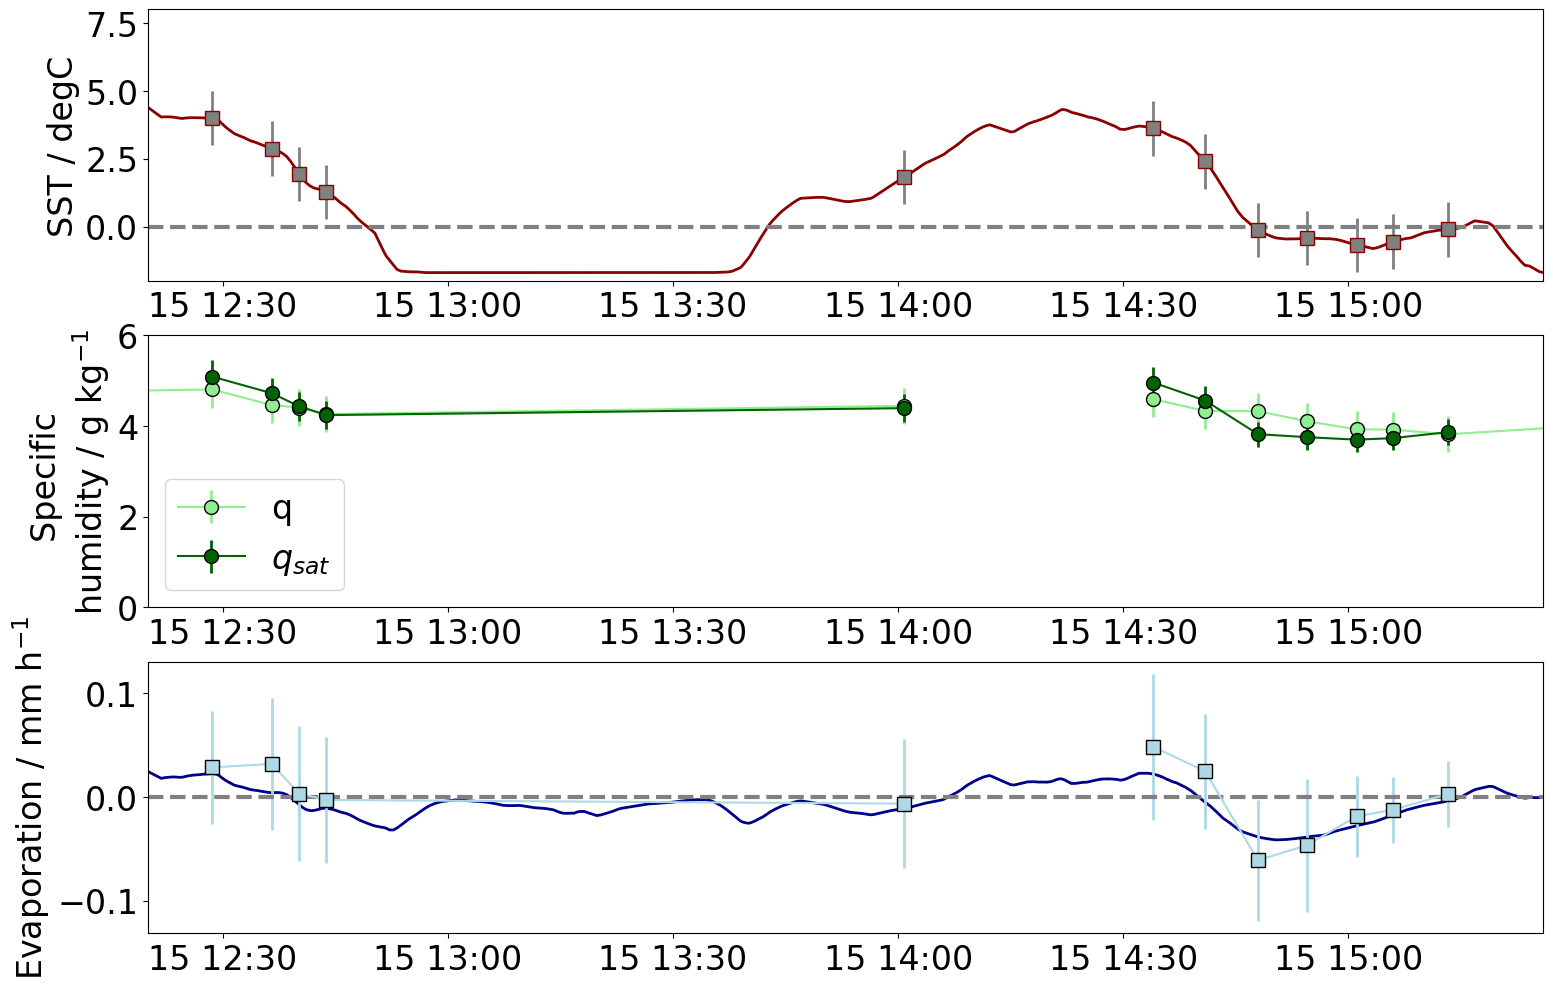

In [14]:
haloac3_evaporation.plot_quantities_quicklook(Evap_cls)

## Manuscript Figure

if flight is RF05 and AR entire_1 then it creates the manuscript plot (fig.08) otherwise it is a supplement illustrating the others

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/..//plots//supplements/Sonde_Evap_RF05_S2.png


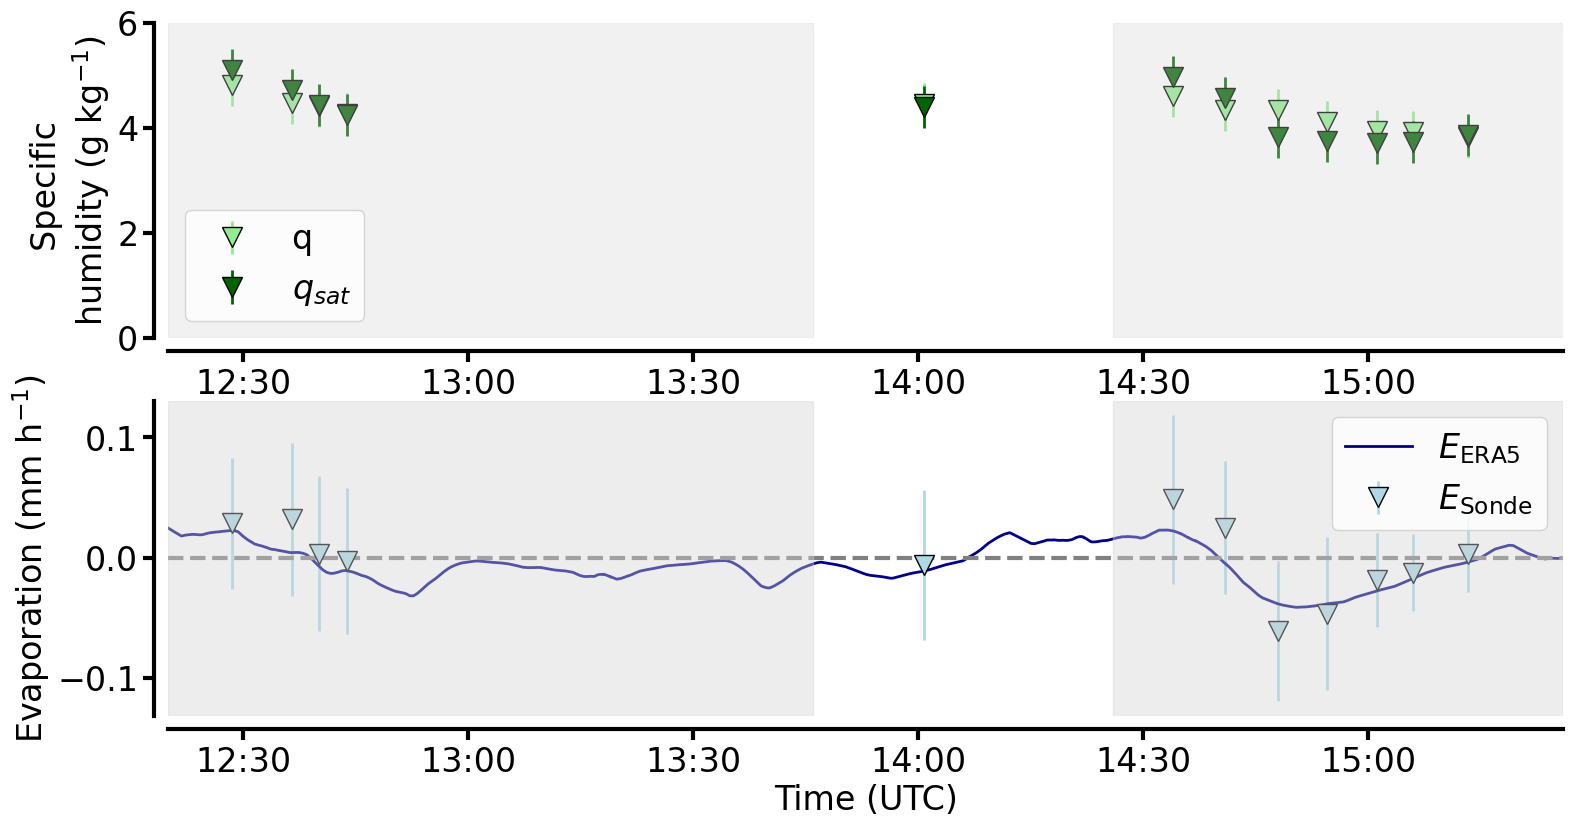

In [15]:
haloac3_evaporation.plot_evap_internal(Evap_cls,warm_internal_halo)

#### Calc internal average

In [16]:
internal_mean_evap=haloac3_evaporation.Evap_cls.evap_mm_h.loc[warm_internal_halo.index[0]:warm_internal_halo.index[-1]].mean()
internal_mean_evap_unc=abs(haloac3_evaporation.Evap_cls.evap_mm_h_unc.loc[warm_internal_halo.index[0]:warm_internal_halo.index[-1]]).mean()
print(flight[0]," "+ar_of_day,"internal_mean_evap:",internal_mean_evap,"+/-",internal_mean_evap_unc)

RF05  AR_entire_2 internal_mean_evap: -0.0063798463844389605 +/- 0.06222718531131834


### Save in budget dataframe

In [17]:
evap_series=pd.Series(data=[internal_mean_evap,internal_mean_evap_unc],index=["Evap","Evap_unc"])
haloac3_budget_plots.change_values_in_budget_df(evap_series)

Evap       -0.006380
Evap_unc    0.062227
dtype: float64
    IWV_dt  IWV_dt_unc  ADV_q  ADV_q_unc  DIV_mass  DIV_mass_unc  Precip  \
S1     NaN         NaN    NaN        NaN       NaN           NaN     NaN   
S2     NaN         NaN    NaN        NaN       NaN           NaN     NaN   
S3     NaN         NaN    NaN        NaN       NaN           NaN     NaN   
S4     NaN         NaN    NaN        NaN       NaN           NaN     NaN   

    Precip_min  Precip_max      Evap  Evap_unc  
S1         NaN         NaN  0.007065  0.059248  
S2         NaN         NaN -0.006380  0.062227  
S3         NaN         NaN  0.056166  0.061512  
S4         NaN         NaN  0.089814  0.052798  
budget df saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/HALO_AC3/data/budgets/Warm_Sectors_budget_components.csv


In [18]:
haloac3_budget_plots.budget_df

,IWV_dt,IWV_dt_unc,ADV_q,ADV_q_unc,DIV_mass,DIV_mass_unc,Precip,Precip_min,Precip_max,Evap,Evap_unc
S1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007065,0.059248
S2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006380,0.062227
S3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.056166,0.061512
S4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089814,0.052798
